In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import time
import datetime
import warnings
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import pandas
import numpy
import scipy.stats
import abcutils

numpy.random.seed(int(time.mktime(datetime.datetime.now().timetuple())))

## Load and Synthesize Data from CSV

This process loads each summary CSV file, creates a few derived metrics, and then merges each system's CSV into a single global dataset that can be sliced and diced by system, benchmark, or any other way.  We are now caching the processed CSV in HDF5 format to speed up initial data ingest at the beginning of each analysis.  Delete the `CACHE_FILE` to re-generate this cache (e.g., when the contents of the CSV are updated).

In [4]:
filtered_df = abcutils.sc18paper.load_dataset()

Loading from cache cache.hdf5
Start with 14536 rows before filtering
Dropped 42 rows after filter #0 (14494 left)
Dropped 14 rows after filter #1 (14480 left)
Dropped 38 rows after filter #2 (14442 left)
Dropped 5 rows after filter #3 (14437 left)
Dropped 2451 rows after filter #4 (11986 left)
11986 rows remaining


## Demonstrate a Single Test Platform

Look at one combination of (compute system, file system, benchmark) to show what this UMAMI analysis can do.

### Define Input Parameters

In [5]:
# TEST_PLATFORM = 'scratch2@edison'
# TEST_PLATFORM = 'cscratch@cori-knl'
# TEST_PLATFORM = 'cscratch@cori-haswell'
TEST_PLATFORM = 'mira-fs1@mira'

# BENCHMARK_ID = 'ior_fpp_write'
BENCHMARK_ID = 'dbscan_read_shared_read'
# BENCHMARK_ID = 'vpicio_uni_shared_write'
# BENCHMARK_ID = 'ior_shared_write'
# BENCHMARK_ID = 'hacc_io_read_fpp_read'

plot_metric = 'darshan_normalized_perf_by_max'
delta = datetime.timedelta(days=1).total_seconds()

group_by = ['_test_platform', '_benchmark_id']

filtered_df['random'] = numpy.random.random((len(filtered_df), ))

example_df = filtered_df.groupby(by=group_by).get_group((TEST_PLATFORM, BENCHMARK_ID)).copy()

print "test_platform =", TEST_PLATFORM
print "benchmark_id =", abcutils.CONFIG['benchmark_labels'].get(BENCHMARK_ID, BENCHMARK_ID)
print "plot_metric =", abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric)
print "date_start =", abcutils.sc18paper.DATE_START.isoformat()
print "date_end =", abcutils.sc18paper.DATE_END.isoformat()

test_platform = mira-fs1@mira
benchmark_id = BD-CATS shared-file read
plot_metric = Fraction Peak Perf
date_start = 2017-02-14T00:00:00
date_end = 2018-02-15T00:00:00


In [6]:
# Width of simple moving average (SMA) short/long windows
short_window = abcutils.features.SHORT_WINDOW
long_window = abcutils.features.LONG_WINDOW
short_window = pandas.Timedelta(days=14)
long_window = pandas.Timedelta(days=49)

min_measures = abcutils.features.MIN_REGION

print "Short window will average over %s measurements at a time" % short_window
print "Long window will average over %s measurements at a time" % long_window
print "Ignoring regions with fewer than %d measurements" % min_measures

Short window will average over 14 days 00:00:00 measurements at a time
Long window will average over 49 days 00:00:00 measurements at a time
Ignoring regions with fewer than 7 measurements


In [7]:
# Metrics to include in UMAMI renderings and analysis.  Anything that
# _might_ affect performance should be included here.
umami_rows = {
    'darshan_normalized_perf_by_max': "Application Performance",
    'coverage_factor_bw': "Bandwidth CF",
#   'coverage_factor_nodehrs',
    'coverage_factor_opens': "open(2) CF",
    'coverage_factor_stats': "stat(2) CF",
    'coverage_factor_ops': "IOPS CF",
    'fs_ave_mds_cpu': "Metadata Server Load",
#   'fs_tot_metadata_ops',
    'fs_ave_oss_cpu': "Data Server Load",
#   'fs_tot_open_ops',
    'fshealth_ost_most_full_pct': "File System Fullness",
    'fshealth_ost_overloaded_oss_count': "LUN Failover Count",
#   'jobsdb_concurrent_nodes',
    'topology_job_max_radius': "Max Job Radius",
    'random': "Random Variable",
}

## Calculate Simple Moving Averages (SMAs)

Compare a short-window SMA and a long-window SMA and use the places where they cross over to divide the entire year into _regions_ of interesting benchmark behavior.

For each region defined above, find the _minimum_ performance observed and denote that measurement (and its associated job) as a _locus_.  We then collate all _loci_ into a set of poorly performing benchmarks that are worth contextualizing with UMAMI.

We also plot the raw performance data (light blue bars), the short SMA (orange line), the long SMA (green line), and all loci (red bars) to visually verify that the loci we've identified are indeed poorly performing jobs.

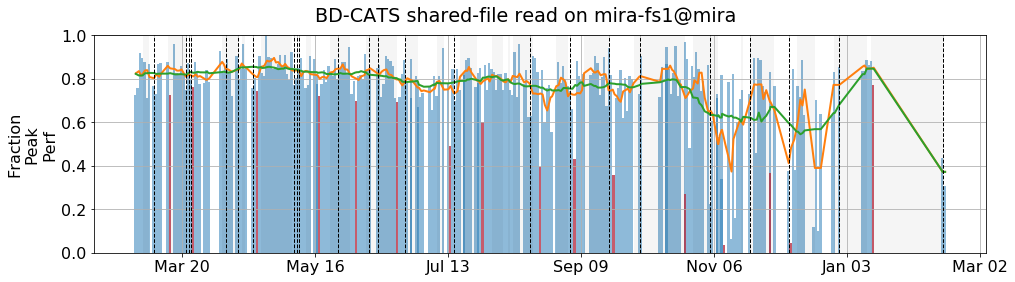

In [8]:
intercepts = abcutils.features.sma_intercepts(example_df, plot_metric, short_window=short_window, long_window=long_window)
loci = abcutils.features.generate_loci_sma(example_df,
                                           plot_metric,
                                           mins=True,
                                           maxes=False,
                                           short_window=short_window,
                                           long_window=long_window)

ax = abcutils.plot.locus_summary(example_df, plot_metric, loci, align="edge")
ax.get_figure().suptitle("%s on %s" % (abcutils.CONFIG['benchmark_labels'].get(BENCHMARK_ID, BENCHMARK_ID), TEST_PLATFORM))

# Add boundaries
ymin, ymax = ax.set_ylim(0, 1)
for x in intercepts['_datetime_start']:
    ax.plot([abcutils.core.pd2epoch(x), abcutils.core.pd2epoch(x)], [ymin, ymax], color='black', linestyle='--', linewidth=1)

In [9]:
intercepts

,_datetime_start,sma_long,sma_short
index,,,
916,2017-03-07 20:28:55,0.820024,0.831706
1409,2017-03-21 15:34:45,0.826290,0.821501
1473,2017-03-22 21:08:55,0.826290,0.829345
1481,2017-03-23 21:26:15,0.830138,0.826746
1893,2017-04-08 04:46:08,0.840589,0.845782
2037,2017-04-13 12:44:47,0.841645,0.840199
2267,2017-04-19 19:20:54,0.842678,0.850094
2978,2017-05-07 20:29:43,0.844533,0.840784
3018,2017-05-08 22:57:06,0.841788,0.843263


In [10]:
print len(loci)
loci

16


,_datetime_start,darshan_normalized_perf_by_max,region_end,region_start
index,,,,
1150,2017-03-14 21:28:15,0.727371,1409,916
1545,2017-03-24 22:37:38,0.763364,1893,1481
2361,2017-04-21 22:43:57,0.744814,2978,2267
3423,2017-05-18 22:02:02,0.719494,3743,3058
4053,2017-06-04 04:06:34,0.699308,4257,3743
4700,2017-06-22 08:50:51,0.694130,4788,4401
5353,2017-07-14 20:47:21,0.492125,5369,4788
5577,2017-07-28 22:01:32,0.603830,5934,5369
6125,2017-08-22 21:57:28,0.395747,6560,5934


## Generate UMAMI Diagrams Around Loci

Generate UMAMI diagrams that _end_ at each locus and have `long_window` days' of benchmark data preceding them.  Don't bother creating UMAMI diagrams for benchmarks with fewer than `short_window` benchmark data in the preceding `long_window` days.

Note that this process mixes up the semantic meaning of `long_window`.  When defining loci, `long_window` refers to a number of benchmark measurements, not days.  Ideally, one benchmark runs each day so this semantic difference is trivial.  However in reality, there are days when no benchmarks are run meaning loci are defined using a series of `long_window` benchmark measurements that often span _more than_ `long_window` days.

Practically speaking, this does not change very much as long as the ratio of `long_window` in days to `long_window` in benchmark measurements is close to 1.0.

Rendering a maximum of 1 UMAMI diagrams
2017-03-07 20:28:55 916 1409


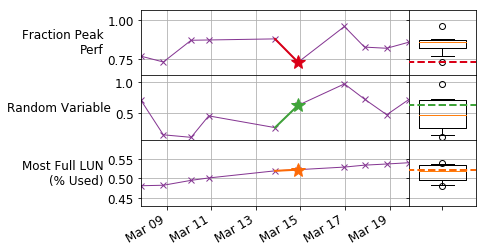

In [11]:
max_renders = 1

print "Rendering a maximum of %d UMAMI diagrams" % max_renders

rendered = 0
for locus in loci.itertuples():
    region_idx0 = example_df.index.get_loc(locus.region_start)
    region_idxf = example_df.index.get_loc(locus.region_end)
    if locus.region_start == locus.Index and region_idx0 > 0:
        region_idx0 -= 1

    print example_df.iloc[region_idx0]['_datetime_start'], \
          example_df.index[region_idx0], \
          example_df.index[region_idxf]
    umami_region = example_df.iloc[region_idx0:region_idxf]
    if len(umami_region) >= min_measures:
        abcutils.plot.generate_umami(umami_region, umami_rows.keys(), highlight_index=umami_region.index.get_loc(locus.Index))
        rendered += 1
        if rendered == max_renders:
            break
    else:
        print "Skipping locus at %s because it has only %d data points (%d required)" % (umami_region['_datetime_start'], len(umami_region), short_window)

BD-CATS shared-file read on mira-fs1@mira
Saving to figs/shortterm-mirafs1-dbscan.pdf


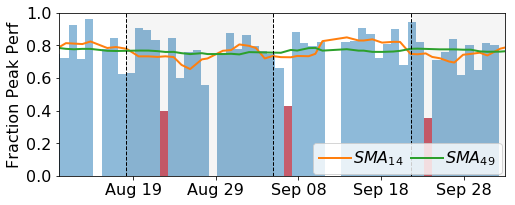

In [12]:
loci = abcutils.features.generate_loci_sma(example_df,
                                           plot_metric,
                                           mins=True,
                                           maxes=False,
                                           short_window=short_window,
                                           long_window=long_window)

sma_intercepts = abcutils.features.sma_intercepts(example_df,
                                                  plot_metric,
                                                  short_window,
                                                  long_window)

ax = abcutils.plot.locus_summary(example_df,
                                 plot_metric,
                                 loci,
                                 sma_intercepts=sma_intercepts,
                                 align='edge',
                                 regioncolors=['#0000000A', '#FFFFFF00'])

# This corresponds to one of the UMAMIs identified above
#ax.set_xlim(
#    abcutils.core.pd2epoch(pandas.Timestamp(datetime.datetime(2017,  9, 21))),
#    abcutils.core.pd2epoch(pandas.Timestamp(datetime.datetime(2017, 10,  1)))
#)

# This corresponds to a pretty region to graph
ax.set_xlim(
    abcutils.core.pd2epoch(pandas.Timestamp(datetime.datetime(2017,  8, 10))),
    abcutils.core.pd2epoch(pandas.Timestamp(datetime.datetime(2017, 10, 3)))
)

# Add boundaries
ymin, ymax = ax.get_ylim()
for x in sma_intercepts['_datetime_start']:
    ax.plot([abcutils.core.pd2epoch(x), abcutils.core.pd2epoch(x)], [ymin, ymax], color='black', linestyle='--', linewidth=1)

ax.grid(False)
ax.set_ylim(0, 1)
ax.get_figure().set_size_inches(8,3)
ax.set_ylabel(ax.get_ylabel().replace("\n", " "))
abcutils.plot.fix_xticks_timeseries(ax, format="%b %d", ha="center", rotation=0, criteria=(lambda x: x.toordinal() % 10 == 0))

ax.get_lines()[0].set_label("$SMA_{%d}$" % short_window.days)
ax.get_lines()[1].set_label("$SMA_{%d}$" % long_window.days)
ax.legend(loc='lower right',
          bbox_to_anchor=(1.01, -0.04),
          ncol=2,
          handletextpad=0.1,
          columnspacing=0.5)

print "%s on %s" % (abcutils.CONFIG['benchmark_labels'].get(BENCHMARK_ID, BENCHMARK_ID), TEST_PLATFORM)

output_file = "figs/shortterm-%s-%s.pdf" % (TEST_PLATFORM.split('@', 1)[0].replace('-', ''), BENCHMARK_ID.split('_', 1)[0])
print "Saving to", output_file
ax.get_figure().savefig(output_file, bbox_inches='tight')

## Tabulate frequency of different problems

Because we define loci to be local minima (i.e., the worst benchmark measured in a temporally local region), all of the UMAMIs we generated above _should_ end on an extremely bad day.  To automatically identify the possible causes for bad performance at each locus, we look at all of the UMAMI metrics and flag those that also ended on extremely poor (e.g., worst quartile) values.  This is exactly the same process we used in the PDSW'17 paper's case studies, but now we have automated the process.

With this method of flagging, we keep a running total of metrics that were flagged as possible culprits as we examine each locus.  Note that multiple metrics can be flagged for a single locus (e.g., low coverage factor _and_ high MDS load can both be flagged for a single benchmark run), so the sum of flags over all metrics will usually add up to more than the total number of loci.

In [13]:
def print_extreme_measurements(results):
    print "Classified: %d" % results['totals'].get('classified', -0)
    print "Unclassified: %d" % results['totals'].get('unclassified', -0)
    print "Ignored: %d" % results['totals'].get('ignored', -0)
    print "Errors: %d" % results['totals'].get('errors', -0)
    print
    for key in reversed(sorted(results['per_metric'].keys(), key=lambda x: results['per_metric'][x])):
        if not key.startswith('_'):
            print "%3d %s" % (results['per_metric'][key], abcutils.CONFIG['metric_labels'].get(key, key))

In [14]:
classified_extremes = abcutils.classify.classify_extreme_measurements(example_df,
                                                                      plot_metric,
                                                                      umami_rows.keys(),
                                                                      want_good=False,
                                                                      classifier='minmax',
                                                                      short_window=short_window,
                                                                      long_window=long_window,)

print_extreme_measurements(classified_extremes)

Classified: 9
Unclassified: 7
Ignored: 0
Errors: 0

  4 Coverage Factor (IOPS)
  4 Random Variable
  3 Coverage Factor (open ops)
  3 Coverage Factor (Bandwidth)
  1 Most Full LUN (% Used)


## Tabulate contributors to bad performance over all tests

We now apply the above analysis to the entirety of the benchmark data across all systems.

Note that warnings about certain loci not being in the worst quartile indicate that the SMA-based method we use to identify local minima is not perfect.  There are a variety of other methods (including some canned algorithms) that we can swap in to improve our classification of loci.

In [15]:
classified_extremes = abcutils.classify.classify_extreme_measurements(filtered_df,
                                                                      plot_metric,
                                                                      umami_rows.keys(),
                                                                      want_good=False,
#                                                                     classifier='percentile',
                                                                      classifier='minmax',
                                                                      short_window=short_window,
                                                                      long_window=long_window)

print_extreme_measurements(classified_extremes)

Classified: 433
Unclassified: 219
Ignored: 0
Errors: 0

198 Coverage Factor (Bandwidth)
118 Coverage Factor (open ops)
 84 Coverage Factor (stat ops)
 78 Average OSS CPU Load (%)
 71 Most Full LUN (% Used)
 62 Average MDS CPU Load (%)
 50 Random Variable
 31 Maximum Job Radius
 29 Number of Overloaded OSSes
 26 Coverage Factor (IOPS)


In [16]:
classified_extremes['per_metric']

{'_datetime_start': 38,
 '_loci_unclassified': 219,
 '_mystery_value': 3.015946755970909,
 '_pval__datetime_start': 0.08630385505190477,
 '_pval_coverage_factor_bw': 0.07796581648613096,
 '_pval_coverage_factor_opens': 0.07867651780515546,
 '_pval_coverage_factor_ops': 0.06671599939594093,
 '_pval_coverage_factor_stats': 0.24598453995750433,
 '_pval_fs_ave_mds_cpu': 0.08468003275343318,
 '_pval_fs_ave_oss_cpu': 0.08033155867885589,
 '_pval_fshealth_ost_most_full_pct': 0.09280071269548804,
 '_pval_fshealth_ost_overloaded_oss_count': 0.7010741150834031,
 '_pval_random': 0.08600034694006678,
 '_pval_topology_job_max_radius': 0.08178824417577321,
 '_tot__datetime_start': 652,
 '_tot_coverage_factor_bw': 632,
 '_tot_coverage_factor_opens': 633,
 '_tot_coverage_factor_ops': 99,
 '_tot_coverage_factor_stats': 534,
 '_tot_darshan_normalized_perf_by_max': 652,
 '_tot_fs_ave_mds_cpu': 534,
 '_tot_fs_ave_oss_cpu': 534,
 '_tot_fshealth_ost_most_full_pct': 652,
 '_tot_fshealth_ost_overloaded_oss_co

### Attempt to calculate the theoretical p-value for a random variable

Mystery is the average 1/N over all loci in a $J_{app,rw,sys}$

In [17]:
sums = {}
counts = {}
nmean = {}
mystery = {}
print "tot should not change, but it does--this is not good"
for result in classified_extremes['per_test']:
    for key, val in result.iteritems():
        if key.startswith('_pval_'):
            tot = result['_loci_classified'] + result['_loci_unclassified']
            sums[key] = sums.get(key, 0.0) + val * tot
            counts[key] = counts.get(key, 0) + tot
            mystery[key] = mystery.get(key, 0.0) + result['_mystery_value'] * tot
            if 'random' in key:
                print key, "%.4f" % val, tot, result['_mystery_value']
print
for key, val in sums.iteritems():
    print key, val / counts[key], mystery[key] / counts[key]
    
classified_extremes['per_test']

_pval_random 0.1008 18 0.0744044006867
_pval_random 0.0903 16 0.0739777583528
_pval_random 0.0662 18 0.0716229513043
_pval_random 0.0994 16 0.0751703187894
_pval_random 0.0769 16 0.0788029066522
_pval_random 0.1111 13 0.0683088660565
_pval_random 0.1066 17 0.0889047499342
_pval_random 0.0714 13 0.0758435397349
_pval_random 0.0627 15 0.0724698918817
_pval_random 0.0714 17 0.0829957795023
_pval_random 0.0500 16 0.0774430685736
_pval_random 0.1111 16 0.0785976979354
_pval_random 0.1010 15 0.0906362740573
_pval_random 0.1007 19 0.0808892291783
_pval_random 0.0521 17 0.0697010542866
_pval_random 0.0909 18 0.0826773046083
_pval_random 0.0651 17 0.0734301662238
_pval_random 0.0909 16 0.0844140061328
_pval_random 0.1000 18 0.0684399665396
_pval_random 0.0538 15 0.0623664648967
_pval_random 0.1080 17 0.0799289834541
_pval_random 0.1429 16 0.0677497964998
_pval_random 0.0620 17 0.0724729108756
_pval_random 0.0843 17 0.0688884896582
_pval_random 0.0662 16 0.0643362361699
_pval_random 0.1000 16 0.

[{'_benchmark_id': 'dbscan_read_shared_read',
  '_datetime_start': 1,
  '_loci_classified': 14,
  '_loci_errors': 0,
  '_loci_ignored': 0,
  '_loci_unclassified': 4,
  '_mystery_value': 0.0686958004948874,
  '_pval__datetime_start': 0.043478260869565216,
  '_pval_coverage_factor_bw': 0.07157829915182856,
  '_pval_coverage_factor_opens': 0.07749287749287749,
  '_pval_coverage_factor_stats': 0.08846153846153847,
  '_pval_fs_ave_mds_cpu': 0.06971153846153846,
  '_pval_fs_ave_oss_cpu': 0.07211885336885338,
  '_pval_fshealth_ost_most_full_pct': 0.07692307692307693,
  '_pval_fshealth_ost_overloaded_oss_count': 0.8181818181818182,
  '_pval_topology_job_max_radius': 0.07213203463203463,
  '_test_platform': 'cscratch@cori-knl',
  '_tot__datetime_start': 18,
  '_tot_coverage_factor_bw': 18,
  '_tot_coverage_factor_opens': 18,
  '_tot_coverage_factor_stats': 18,
  '_tot_darshan_normalized_perf_by_max': 18,
  '_tot_fs_ave_mds_cpu': 18,
  '_tot_fs_ave_oss_cpu': 18,
  '_tot_fshealth_ost_most_full_pc

The following bar graph shows the total number of times each metric has been flagged as a possible source of performance loss as defined above: its value was "bad" coincident with each locus, where a locus is a job whose performance was abnormally poor and "bad" is defined as being within the 25th worst percentile.

In [18]:
def fix_axis_labels(ax, rotation=45):
    reverse_map = {}
    new_labels = []
    for key, value in abcutils.CONFIG['metric_labels'].iteritems():
        reverse_map[value] = key
    for xlabel in [x.get_text() for x in ax.get_xticklabels()]:
        if xlabel in reverse_map and reverse_map[xlabel] in umami_rows:
            new_labels.append(umami_rows[reverse_map[xlabel]])
        else:
            new_labels.append(xlabel)
    ax.set_xticklabels(new_labels, rotation=rotation)

Candidate Contributors to Bad Performance (652 Jobs Total)


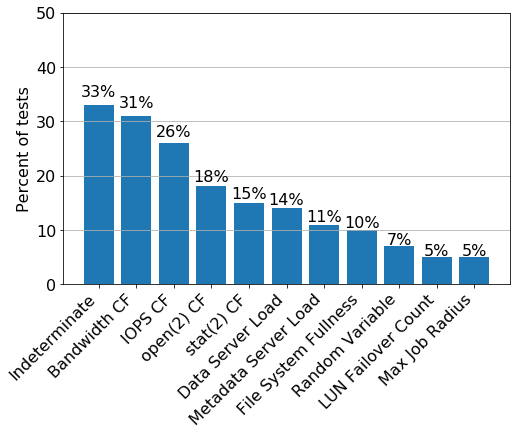

In [19]:
ax = abcutils.plot.classified_extremes_summary(classified_extremes)
ax.get_figure().set_size_inches(8, 5)
ax.set_ylim(0, 50)
fix_axis_labels(ax)
print "Candidate Contributors to Bad Performance (%d Jobs Total)" % classified_extremes['totals']['total']

Candidate Contributors to Bad Performance (652 Jobs Total)


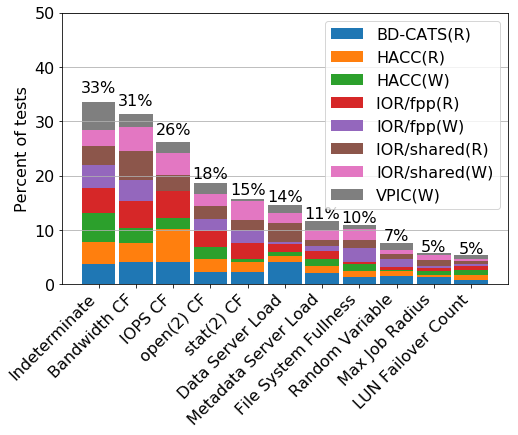

In [20]:
ax = abcutils.plot.classified_extremes_summary_grouped(classified_extremes, group_metric='_benchmark_id')
ax.get_figure().set_size_inches(8, 5)
ax.set_ylim(0, 50)
fix_axis_labels(ax)
print "Candidate Contributors to Bad Performance (%d Jobs Total)" % classified_extremes['totals']['total']

Candidate Contributors to Bad Performance (652 Jobs Total)


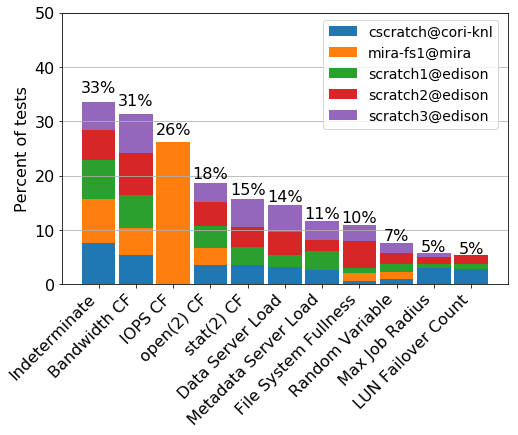

In [21]:
ax = abcutils.plot.classified_extremes_summary_grouped(classified_extremes, group_metric='_test_platform')
ax.get_figure().set_size_inches(8, 5)
ax.set_ylim(0, 50)
ax.legend(bbox_to_anchor=(0.57, 1.0), fontsize=14)
fix_axis_labels(ax)
ax.get_figure().savefig('figs/contributors-bad-by-system.pdf', bbox_inches='tight')
print "Candidate Contributors to Bad Performance (%d Jobs Total)" % classified_extremes['totals']['total']

There are many caveats with the above plot; notably, the majority of jobs were run on Lustre since this data includes all Edison, Cori+KNL, and Cori+Haswell jobs.  In addition, the Mira data does not currently contain file system health data (although it is available), so the "Number of Overloaded OSSes" may be underreported.

The most appropriate way to present this data is to produce one bar graph per test platform (compute system + file system combination) so that metrics that are only available on one test platform aren't being directly compared with others that are.

## Tabulate contributors to good performance over all tests

We can also perform the above analysis and look for the metrics that coincided with good performance.

In [22]:
classified_extremes = abcutils.classify.classify_extreme_measurements(filtered_df,
                                                                      plot_metric,
                                                                      umami_rows.keys(),
                                                                      want_good=True,
                                                                      classifier='minmax')
print_extreme_measurements(classified_extremes)

Classified: 579
Unclassified: 298
Ignored: 0
Errors: 0

168 Coverage Factor (Bandwidth)
155 Coverage Factor (open ops)
150 Most Full LUN (% Used)
110 Average MDS CPU Load (%)
107 Coverage Factor (stat ops)
 88 Random Variable
 66 Maximum Job Radius
 54 Average OSS CPU Load (%)
 21 Number of Overloaded OSSes
 20 Coverage Factor (IOPS)


Text(0.5,1,u'Candidate Contributors to Good Performance (877 Jobs Total)')

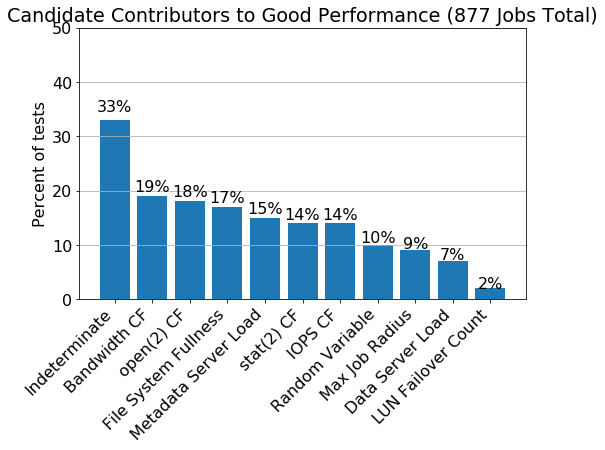

In [23]:
ax = abcutils.plot.classified_extremes_summary(classified_extremes)
ax.get_figure().set_size_inches(8, 5)
ax.set_ylim(0, 50)
fix_axis_labels(ax)
ax.set_title("Candidate Contributors to Good Performance (%d Jobs Total)" % classified_extremes['totals']['total'])

Text(0.5,1,u'Candidate Contributors to Good Performance (877 Jobs Total)')

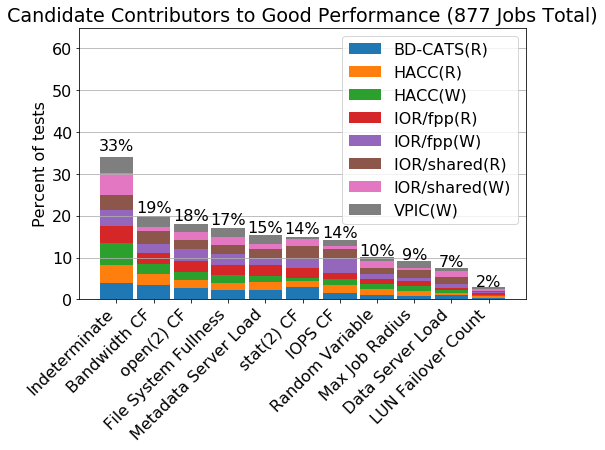

In [24]:
ax = abcutils.plot.classified_extremes_summary_grouped(classified_extremes, group_metric='_benchmark_id')
ax.get_figure().set_size_inches(8, 5)
ax.set_ylim(0, 65)
fix_axis_labels(ax)
ax.set_title("Candidate Contributors to Good Performance (%d Jobs Total)" % classified_extremes['totals']['total'])

## Compare Classifiers

Using the minmax classifier:
Classified: 634
Unclassified: 243
Ignored: 0
Errors: 0

282 Coverage Factor (Bandwidth)
199 Coverage Factor (open ops)
133 Most Full LUN (% Used)
118 Coverage Factor (stat ops)
111 Average MDS CPU Load (%)
103 Average OSS CPU Load (%)
 92 Random Variable
 63 Maximum Job Radius
 36 Coverage Factor (IOPS)
 21 Number of Overloaded OSSes



/opt/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Using the percentile classifier:
Classified: 766
Unclassified: 111
Ignored: 0
Errors: 0

435 Coverage Factor (Bandwidth)
376 Coverage Factor (open ops)
247 Most Full LUN (% Used)
242 Average MDS CPU Load (%)
226 Random Variable
186 Coverage Factor (stat ops)
165 Average OSS CPU Load (%)
150 Maximum Job Radius
 68 Coverage Factor (IOPS)
  4 Number of Overloaded OSSes



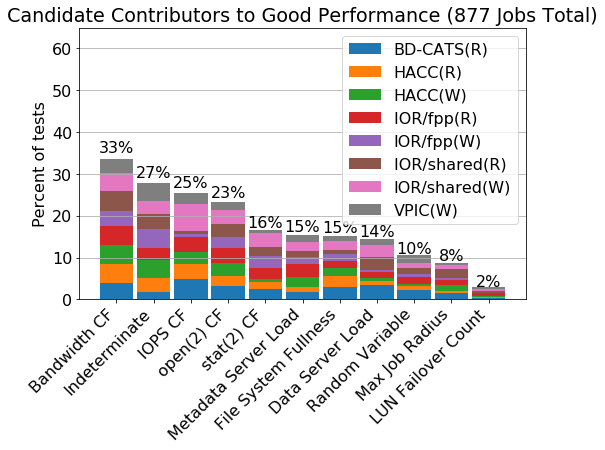

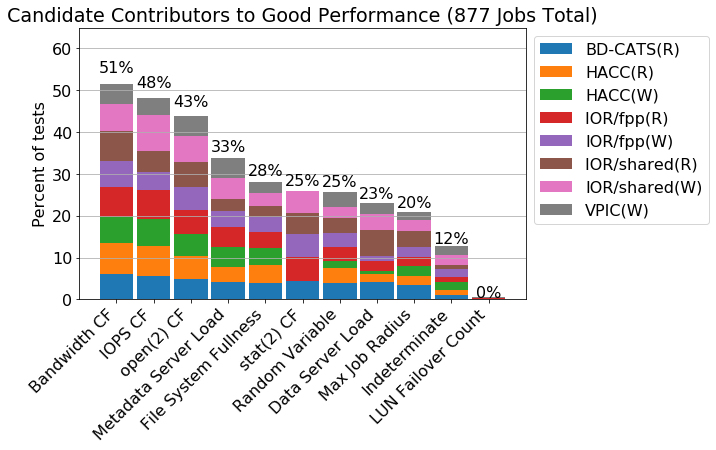

In [25]:
for classifier in abcutils.classify.CLASSIFIERS.keys():
    classified_extremes = abcutils.classify.classify_extreme_measurements(filtered_df, plot_metric, umami_rows.keys(), want_good=False, classifier=classifier)
    print "Using the %s classifier:" % classifier
    print_extreme_measurements(classified_extremes)
    print
    ax = abcutils.plot.classified_extremes_summary_grouped(classified_extremes, group_metric='_benchmark_id')
    ax.get_figure().set_size_inches(8, 5)
    ax.set_ylim(0, 65)
    fix_axis_labels(ax)
    ax.set_title("Candidate Contributors to Good Performance (%d Jobs Total)" % classified_extremes['totals']['total'])